In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt

def _cosine_variance_schedule(timesteps, epsilon=0.003, power=2.0):
    steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
    f_t = (
        torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5)
        ** power
    )
    # betas = torch.clip(1.0 - f_t[1:] / f_t[:timesteps], 0.0, 0.999)
    betas = torch.clip(1.0 - f_t[1:] / f_t[:timesteps], 0.0, 0.999)

    return betas

In [20]:
states = 20

betas = _cosine_variance_schedule(states, power=2.0)
alphas = 1.0 - betas
alphas_bar = alphas.cumprod(dim=-1)
sqrt_alpha_bar = alphas_bar.sqrt()
sqrt_1_sub_alpha_b = (1.0 - alphas_bar).sqrt()

In [21]:
def forward_diffusion(
        clean_data: torch.Tensor, noise : torch.Tensor, target: torch.Tensor=None, keep_intermediate: bool = False) -> torch.Tensor:
    if keep_intermediate:
        images = [clean_data]

        for t in range(states-1):
            image_scale = (1-betas[t]).sqrt()
            noise_scale = betas[t].sqrt()
            noised = image_scale * images[-1] + noise_scale * torch.randn_like(
                clean_data
            )
            # noised = torch.clip(noised, min=-1, max=1)
            images.append(noised)

        print

        # concatenate each step into one image for for each sample
        return torch.cat(images, dim=1)

    else:
        # print(sqrt_alpha_bar)
        # print(target)
        image_scale = sqrt_alpha_bar.gather(0, target.squeeze()).reshape(
            clean_data.shape
        )
        noise_scale = sqrt_1_sub_alpha_b.gather(0, target.squeeze()).reshape(
            clean_data.shape
        )
        noised = image_scale * clean_data + noise_scale * noise
        # noised = torch.clip(noised, min=-1, max=1)
        return noised
    
@torch.no_grad()
def sample(model : nn.Module, amount: int, keep_intermediate: bool) -> torch.Tensor:
    """Sample from the model."""
    # sample noise from standard normal distribution
    image = (
        torch.randn((amount, 1)).float()
    )

    images = [image]

    for t in reversed(range(0, states-1)):
        t_step = t * torch.ones(amount, dtype=int).unsqueeze(1)

        
        image: torch.Tensor = reverse_diffusion(model, images[-1], t_step)
        # print("image", image.shape)
        images.append(image)

    if keep_intermediate:
        # images holds the images from the noisiest to the denoised image
        images = torch.stack(images, dim=1)
        return images

    else:
        return image

@torch.no_grad()
def reverse_diffusion(model : nn.Module, x_t: torch.Tensor, t : torch.Tensor) -> torch.Tensor:
    """Reverse the diffusion process by taking a single step backwards"""
    
    input = torch.cat((x_t, t.float()/states), dim = 1)
    noise_mean_pred = model.forward(input)

    batch_size: int = x_t.shape[0]
    alpha_t = alphas.gather(-1, t.squeeze()).reshape(batch_size, 1)
    
    sqrt_one_minus_alpha_cumprod_t = sqrt_1_sub_alpha_b.gather(
        -1, t.squeeze()
    ).reshape(batch_size, 1)

    x0_prediction = (1.0 / torch.sqrt(alpha_t)) * (x_t - sqrt_one_minus_alpha_cumprod_t * noise_mean_pred)
    # print("x0", x0_prediction.shape)
    # clip it:
    # x0_prediction = torch.clip(x0_prediction, min=-1, max=1)

    if t.min() > 0:
        noise = torch.randn_like(x_t)
        forward_noised_again = forward_diffusion(x0_prediction, noise, t-1, keep_intermediate=False)
        return forward_noised_again
    else:
        return x0_prediction

@torch.no_grad()
def insta_predict_from_t(model, x_t: torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        
    input = torch.cat((x_t, t.float()/states), dim = 1)
    noise_mean_pred = model.forward(input)

    batch_size: int = x_t.shape[0]
    alpha_t = alphas.gather(-1, t.squeeze()).reshape(batch_size, 1)
    
    sqrt_one_minus_alpha_cumprod_t = sqrt_1_sub_alpha_b.gather(
        -1, t.squeeze()
    ).reshape(batch_size, 1)

    x0_prediction = (1.0 / torch.sqrt(alpha_t)) * (x_t - sqrt_one_minus_alpha_cumprod_t * noise_mean_pred)
    # x0_prediction = torch.clip(x0_prediction, min=-1, max=1)
    return x0_prediction
    

In [22]:
data = torch.rand((100, 128, 1)) * 10 - 5
# data = torch.randint(0, 4, (100, 128, 1)).float()
data -= data.mean()
data *= 2

model = nn.Sequential(nn.Linear(2, 64), nn.GELU(), nn.Linear(64, 64), nn.GELU(), nn.Linear(64, 1))


optim = torch.optim.Adam(model.parameters(), lr = 0.001)

for e in range(100):
    loss = 0
    for i, batch in enumerate(data):
        batch_size = batch.shape[0]
        optim.zero_grad()
        noise = torch.randn(size = (batch_size,1))
        t = torch.randint(0, states-1, size=(batch_size,1))

        # print(batch.shape)

        # print("t:",t)
        # print("Noise:", noise.shape)
        noised_batch = forward_diffusion(clean_data=batch, noise=noise, target=t, keep_intermediate=False)

        combined = torch.cat((noised_batch, t.float()/states), dim = 1)
        pred = model(combined)
        # print("combined", combined.shape)
        loss = torch.sum((noise-pred)**2)
        loss.backward()
        loss += loss.item()
        
        optim.step()
    print(loss / data.shape[0])


tensor(2.6031, grad_fn=<DivBackward0>)
tensor(2.2199, grad_fn=<DivBackward0>)
tensor(2.7146, grad_fn=<DivBackward0>)
tensor(2.3886, grad_fn=<DivBackward0>)
tensor(2.1583, grad_fn=<DivBackward0>)
tensor(2.9152, grad_fn=<DivBackward0>)
tensor(2.3806, grad_fn=<DivBackward0>)
tensor(2.3209, grad_fn=<DivBackward0>)
tensor(2.2501, grad_fn=<DivBackward0>)
tensor(2.2090, grad_fn=<DivBackward0>)
tensor(2.3479, grad_fn=<DivBackward0>)
tensor(1.6181, grad_fn=<DivBackward0>)
tensor(1.9006, grad_fn=<DivBackward0>)
tensor(2.8116, grad_fn=<DivBackward0>)
tensor(2.2236, grad_fn=<DivBackward0>)
tensor(2.2635, grad_fn=<DivBackward0>)
tensor(2.5772, grad_fn=<DivBackward0>)
tensor(1.9368, grad_fn=<DivBackward0>)
tensor(2.0003, grad_fn=<DivBackward0>)
tensor(1.7527, grad_fn=<DivBackward0>)
tensor(2.2555, grad_fn=<DivBackward0>)
tensor(2.2155, grad_fn=<DivBackward0>)
tensor(2.3925, grad_fn=<DivBackward0>)
tensor(2.0622, grad_fn=<DivBackward0>)
tensor(2.1992, grad_fn=<DivBackward0>)
tensor(2.3955, grad_fn=<D

torch.Size([128, 20])


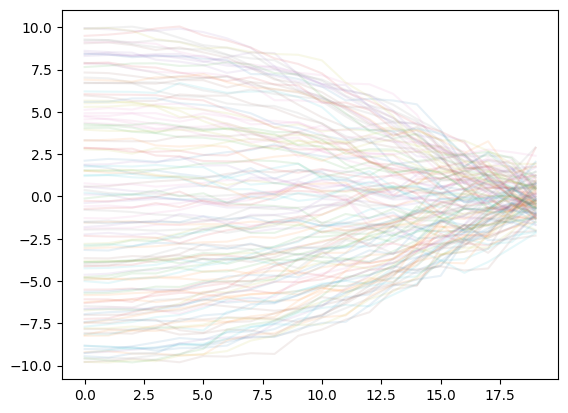

In [23]:
# model = nn.Sequential(nn.Linear(2, 50), nn.GELU(), nn.Linear(50, 1))

samples = forward_diffusion(data[0], torch.randn_like(data[0]), None, True)

print(samples.shape)
for i in samples:
    plt.plot(torch.arange(states, dtype=int), i, alpha=0.1)

torch.Size([128, 1])
torch.Size([128, 1])


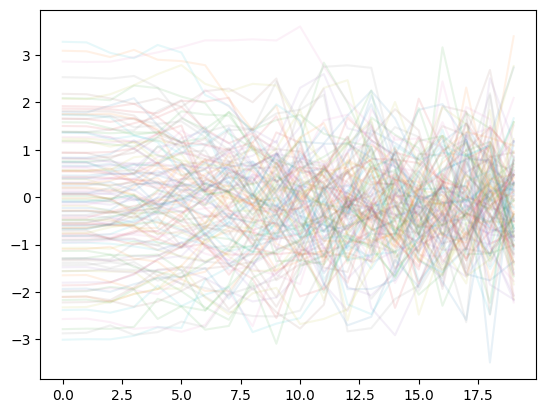

In [24]:
ts = torch.randint(0, states-1, (data[0].shape[0],1))
noised = forward_diffusion(data[0], torch.randn_like(data[0]), ts, False)
instas = insta_predict_from_t(model, noised, ts)
print(instas.shape)
print(ts.shape)

samples = sample(model, data.shape[1], keep_intermediate=True)



for s in samples:
    plt.plot(torch.arange(states), reversed(s), alpha=0.1)
    
# for t, n, i in zip(ts, noised, instas):
#     plt.plot([0, t.item()], [i,n], alpha=0.1, c="r")
